In [19]:
import sys
import os
import gc
import re
import json
import copy
import random

# Scientific Libraries
import numpy as np
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum
from networkx.algorithms.flow import shortest_augmenting_path

# Graph & Plotting\
import matplotlib
matplotlib.use("Agg")

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# MBNpy Modules
import matplotlib
matplotlib.use("Agg")

# Local Module
import batch

# Clean up memory
gc.collect()
%matplotlib inline


In [20]:
import json

json_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\toy_network_probs.json"

with open(json_path, 'r') as f:
    data = json.load(f)

def to_tuple_dict(d):
    return {k: tuple(v) for k, v in d.items()}

nodes = to_tuple_dict(data["nodes"])
edges = to_tuple_dict(data["edges"])
arcs = list(edges.values())
arc_distance = data["arc_distance"]
intact_capacity = data["intact_capacity"]
intact_capacity = {k: float(v) for k, v in intact_capacity.items()}
probs = data.get("probs", {})  

print("nodes = {")
for k, v in nodes.items():
    print(f"    '{k}': {v},")
print("}\n")

print("edges = {")
for k, v in edges.items():
    print(f"    '{k}': {v},")
print("}\n")

print("arc_distance = {")
for k, v in arc_distance.items():
    print(f"    '{k}': {round(v, 2)},")
print("}\n")

print("intact_capacity = {")
for k, v in intact_capacity.items():
    print(f"    '{k}': {round(v, 1)},")
print("}\n")

print("probs = {")
for k, d in probs.items():
    print(f"    '{k}': {{0: {d['0']}, 1: {d['1']}}},")
print("}")


nodes = {
    'n1': (14220973.722359, 4130645.024699),
    'n2': (14146717.100649, 4132230.850867),
    'n3': (14069555.081924, 4135563.205243),
    'n4': (14176063.932488, 4142425.232937),
    'n5': (14193634.040681, 4156553.213346),
    'n6': (14133595.120358, 4161955.794115),
    'n7': (14106102.458275, 4165750.415781),
    'n8': (14364964.734294, 4179610.177365),
    'n9': (14114209.919848, 4182618.141239),
    'n10': (14262065.814782, 4184305.294959),
    'n11': (14187881.60784, 4186131.108938),
    'n12': (14359921.684878, 4191814.358808),
    'n13': (14313076.547757, 4196036.78356),
    'n14': (14171404.111818, 4202524.330698),
    'n15': (14113052.598481, 4204750.16163),
    'n16': (14358584.399463, 4205643.497223),
    'n17': (14341165.230242, 4216763.431199),
    'n18': (14177745.987252, 4219927.831905),
    'n19': (14334781.476341, 4228592.823673),
    'n20': (14119979.491602, 4242381.548748),
    'n21': (14126889.141603, 4272193.648242),
    'n22': (14329842.484908, 4275892

In [21]:
# 3. Compute maximum allowable distance
json_path = r"D:\MINJI\NETWORK RELIABILITY\QGIS\Korea\demand_data.json"
with open(json_path, "r", encoding="utf-8") as f:
    demand = json.load(f)

demand_dict = {}
max_distance = {}
avg_velo = 149  # Speed in km/h
commodity_name_map = {}  
delay_time = 4.7

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],
        "distance": item["distance"]
    }
    max_allowable_ad_distance = avg_velo * delay_time / 60
    max_distance[key] = item["distance"] + max_allowable_ad_distance # 여유 거리 설정

print("Maximum Allowable Distance Per OD Pair:\n")

for k in max_distance:
    base_dist = demand_dict[k]['distance']
    extra_dist = round(max_distance[k] - base_dist, 2)
    print(f"{k}:")
    print(f"  - Origin → Destination: {demand_dict[k]['origin']} → {demand_dict[k]['destination']}")
    print(f"  - Base Distance: {base_dist:.2f} m")
    print(f"  - Extra Allowance: {extra_dist:.2f} m")
    print(f"  - Max Allowable Distance: {max_distance[k]:.2f} m\n")



def generate_comps_st(probs): # 자동으로 2개씩 묶어 state 랜덤 설정하여 컴포넌트 상태 생성
    comps_st = {}

    # edge ID를 정렬해서 2개씩 묶기
    edge_ids = sorted(probs.keys(), key=lambda x: int(x[1:]))  # e1, e2, ..., e10 기준
    edge_pairs = [ (edge_ids[i], edge_ids[i+1]) for i in range(0, len(edge_ids), 2) ]

    for e_fwd, e_bwd in edge_pairs:
        prob_dict = probs[e_fwd]  # e_fwd 기준으로 상태 결정
        states = list(prob_dict.keys())
        probabilities = list(prob_dict.values())
        state = random.choices(states, weights=probabilities, k=1)[0]

        comps_st[e_fwd] = state
        comps_st[e_bwd] = state

    return comps_st


Maximum Allowable Distance Per OD Pair:

k1:
  - Origin → Destination: n3 → n20
  - Base Distance: 126543.16 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 126554.83 m

k2:
  - Origin → Destination: n3 → n21
  - Base Distance: 157145.52 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 157157.19 m

k3:
  - Origin → Destination: n3 → n29
  - Base Distance: 177995.84 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 178007.51 m

k4:
  - Origin → Destination: n3 → n36
  - Base Distance: 218082.46 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 218094.13 m

k5:
  - Origin → Destination: n3 → n37
  - Base Distance: 239467.32 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 239478.99 m

k6:
  - Origin → Destination: n3 → n38
  - Base Distance: 256187.89 m
  - Extra Allowance: 11.67 m
  - Max Allowable Distance: 256199.56 m

k7:
  - Origin → Destination: n7 → n20
  - Base Distance: 79140.86 m
  - Extra Allowance: 11.67 m
  - Max Allowable Dis

In [22]:
# ----------------------------
# 4. MCNF system function
# ----------------------------
def MCNF_systemfunc_test(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance, threshold_ratio):

    edge_map = {v: k for k, v in edges.items()}  # (i, j) → edge_id
    
    model = Model("MCNF")
    model.setParam('OutputFlag', 0)

    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        origin = info['origin']
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unmet_{k}")
        for i, j in arcs:
            edge_id = edge_map.get((i, j))
            cap = arc_capacity.get(edge_id, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=cap, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")



    # Objective
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(quicksum(unmet_demand[k] for k in demand), GRB.MINIMIZE)



    # Flow conservation
    nodes_set = set(n for arc in arcs for n in arc)
    for k, info in demand.items():
        o, d, amt = info['origin'], info['destination'], info['amount']
        for n in nodes_set:
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == n)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == n)
            if n == o:
                model.addConstr(outflow - inflow == amt - unmet_demand[k])
            elif n == d:
                model.addConstr(outflow - inflow == -amt + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Arc capacity
    for i, j in arcs:
        edge_id = edge_map.get((i, j))
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get(edge_id, 0))    

    # Distance limit
        for k, info in demand.items():
            distance_expr = quicksum(arc_distance[edge_map[(i, j)]] * flow[k, i, j] for i, j in arcs if (i, j) in edge_map)
            total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == info['origin'])
            model.addConstr(distance_expr <= max_distance[k] * total_flow)



    model.optimize()

    if model.status == GRB.OPTIMAL:

        expected_loss = model.objVal
        threshold = total_demand * threshold_ratio
        edge_flows = {e: 0.0 for e in edges}
        od_used_edges = {k: set() for k in demand}
        od_flows = {k: [] for k in demand}

        for (k, i, j), var in flow.items():
            if var.x > 0:
                od_flows[k].append(((i, j), var.x))

        for (k, i, j), var in flow.items():
            if var.x > 0:
                edge_id = edge_map.get((i, j))  
                if edge_id:
                    edge_flows[edge_id] += var.X
                    od_used_edges[k].add(edge_id)

        if expected_loss < threshold:
            sys_st = 's'
            min_comps_st = {}
            for (k, i, j), var in flow.items():
                if var.x > 0:
                    edge_id = edge_map.get((i, j))
                    if edge_id:
                        min_comps_st[edge_id] = 1

        else:
            sys_st = 'f'
            min_comps_st = None

        return expected_loss, sys_st, min_comps_st, threshold, edge_flows
    else:
        return None, None, None, None, None

In [23]:
def shortestpath_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance, threshold_ratio):
    import networkx as nx
    from networkx.algorithms.flow import shortest_augmenting_path
    from types import SimpleNamespace

    # 각 컴포넌트의 상태(0/1)에 따른 capacity 값 정의
    varis = {e: SimpleNamespace(values={0: 0, 1: 1}) for e in edges}

    total_demand = sum(info["amount"] for info in demand.values())
    expected_loss = 0.0
    used_links_set = set()
    edge_flows = {e: 0.0 for e in edges}

    for k, info in demand.items():
        origin = info["origin"]
        destination = info["destination"]
        amount = info["amount"]

        # 네트워크 구성
        G = nx.Graph()
        for e, state in comps_st.items():
            u, v = edges[e]
            G.add_edge(u, v, capacity=varis[e].values[int(state)])

        # 도착지에 new_d 노드 연결
        G.add_edge(destination, 'new_d', capacity=1)

        try:
            f_val, f_dict = nx.maximum_flow(G, origin, 'new_d', capacity='capacity',
                                            flow_func=shortest_augmenting_path)
        except:
            f_val = 0
            f_dict = {}

        if f_val == 0:
            expected_loss += amount
        else:
            for e in edges:
                u, v = edges[e]
                flow_uv = f_dict.get(u, {}).get(v, 0)
                flow_vu = f_dict.get(v, {}).get(u, 0)
                if max(flow_uv, flow_vu) > 0:
                    used_links_set.add(e)
                    edge_flows[e] += amount

    threshold = total_demand * threshold_ratio
    expected_loss = min(max(expected_loss, 0.0), total_demand)

    if expected_loss < threshold:
        sys_st = 's'
        min_comps_st = {e: 1 for e in used_links_set}
    else:
        sys_st = 'f'
        min_comps_st = None

    return expected_loss, sys_st, min_comps_st, threshold, edge_flows


In [24]:
# 1) 테스트할 failed edges 목록을 직접 지정
failed = [5,6,29,30,71,72]

# 2) 수동으로 comps_st 구성 (failed에 들어있는 edge는 0, 나머지는 1)
comps_st = {e: (0 if int(e[1:]) in failed else 1) for e in intact_capacity}
arc_capacity = {e: float(intact_capacity[e]) * comps_st[e] for e in intact_capacity}
print(arc_capacity)

sys_fun_mcnf = lambda comps_st: MCNF_systemfunc_test(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity=arc_capacity,
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance, 
    threshold_ratio=0.13
)

sys_fun_shortest = lambda comps_st: shortestpath_systemfunc(
    arcs=arcs,
    comps_st=comps_st,
    demand=demand_dict,
    edges=edges,
    arc_capacity=arc_capacity,
    max_distance=max_distance,
    arc_distance=arc_distance,
    threshold_ratio=0.13
)

print("\n🔹 Input Values:")
print("Component States (comps_st):", comps_st)
print("Edges:", edges)
print("Arc Capacity:", arc_capacity)
print("Demand:", demand_dict)
print("Max Distance:", max_distance)
print("Arc Distance:", arc_distance)

expected_loss_mcnf, sys_st_mcnf, min_comps_st_mcnf, threshold_mcnf, edge_flows_mcnf = sys_fun_mcnf(comps_st)
expected_loss_sp, sys_st_sp, min_comps_st_sp, threshold_sp, edge_flows_sp = sys_fun_shortest(comps_st)


print("\n🔹 Edge Flows:")
if edge_flows_mcnf:
    for e, f in edge_flows_mcnf.items():
        if f > 0:
            print(f"{e}: {f:.2f}")
else:
    print("No valid flows.")

print("\n")
if edge_flows_sp:
    for e, f in edge_flows_sp.items():
        if f > 0:
            print(f"{e}: {f:.2f}")
else:
    print("No valid flows.")


print("\n🔹 Output Values:")
print("System State (MCNF):", sys_st_mcnf)
print("System State (Shortest):", sys_st_sp)
print("Minimum component state (MCNF):", min_comps_st_mcnf) 
print("Minimum component state (Shortest):", min_comps_st_sp) 
print("Expected Loss (MCNF):", expected_loss_mcnf) 
print("Expected Loss (Shortest):", expected_loss_sp)
print("threshold (MCNF):", threshold_mcnf)
print("threshold (Shortest):", threshold_sp) 

{'e1': 1070294.0, 'e2': 1070294.0, 'e3': 567441.0, 'e4': 567441.0, 'e5': 0.0, 'e6': 0.0, 'e7': 118699.0, 'e8': 118699.0, 'e9': 731009.0, 'e10': 731009.0, 'e11': 889216.0, 'e12': 889216.0, 'e13': 4615366.5, 'e14': 4615366.5, 'e15': 305036.99999999994, 'e16': 305036.99999999994, 'e17': 269834.0, 'e18': 269834.0, 'e19': 348604.99999999994, 'e20': 348604.99999999994, 'e21': 1443290.0, 'e22': 1443290.0, 'e23': 208162.0, 'e24': 208162.0, 'e25': 529316.0, 'e26': 529316.0, 'e27': 206304.49999999997, 'e28': 206304.49999999997, 'e29': 0.0, 'e30': 0.0, 'e31': 17360.5, 'e32': 17360.5, 'e33': 13212.0, 'e34': 13212.0, 'e35': 389297.5, 'e36': 389297.5, 'e37': 1371198.0, 'e38': 1371198.0, 'e39': 5069035.5, 'e40': 5069035.5, 'e41': 3670.0, 'e42': 3670.0, 'e43': 743219.5, 'e44': 743219.5, 'e45': 5530552.0, 'e46': 5530552.0, 'e47': 1926450.5, 'e48': 1926450.5, 'e49': 4754412.0, 'e50': 4754412.0, 'e51': 188254.49999999997, 'e52': 188254.49999999997, 'e53': 365240.99999999994, 'e54': 365240.99999999994, 'e

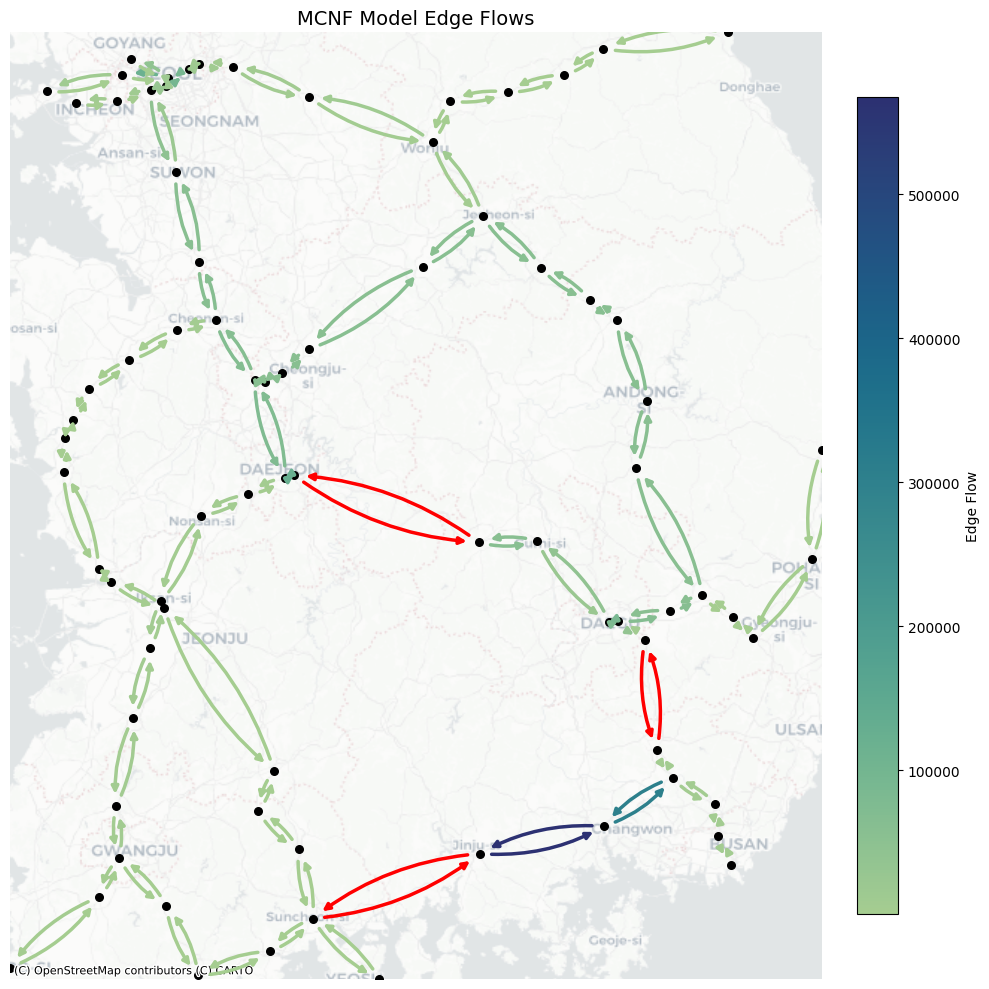

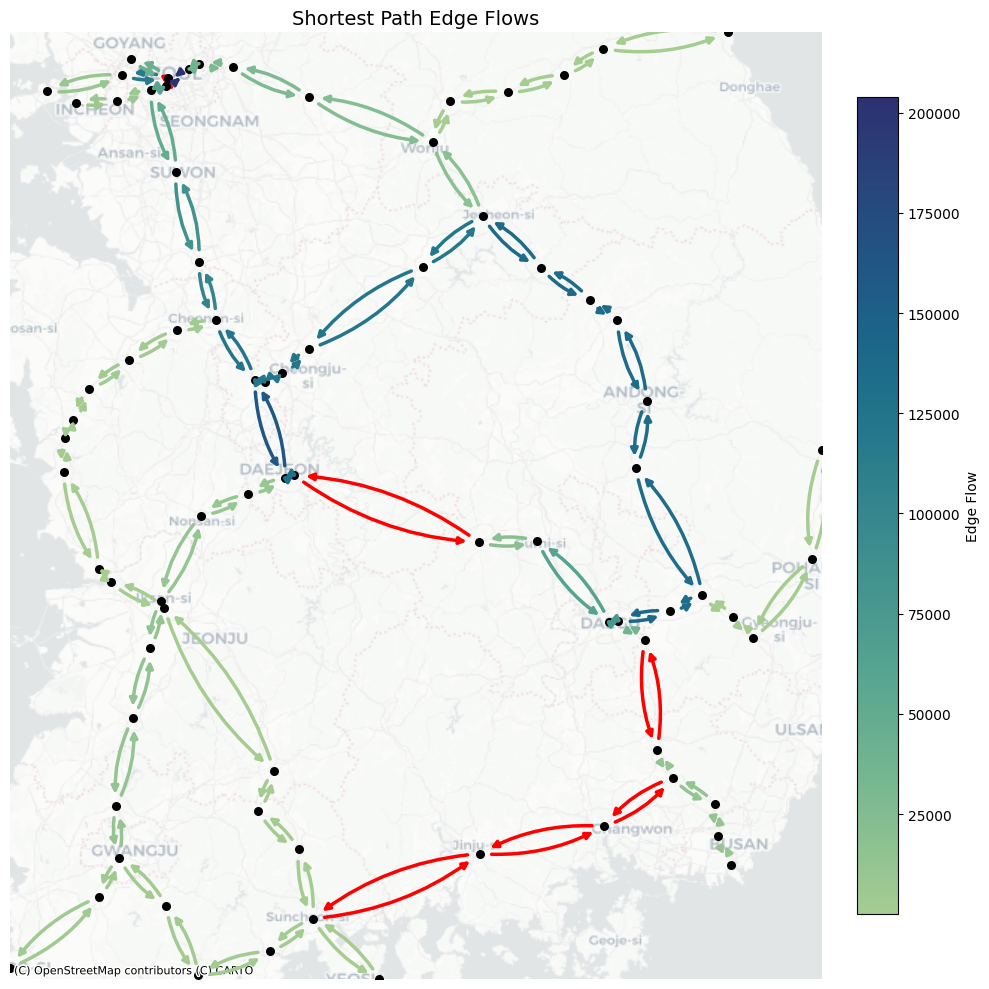

In [25]:
# 2) networkx 그래프 생성
G_mcnf = nx.DiGraph()
G_sp   = nx.DiGraph()

for node, pos in nodes.items():
    G_mcnf.add_node(node, pos=pos)
    G_sp.add_node(node,   pos=pos)

pos_mcnf = nx.get_node_attributes(G_mcnf, "pos")
pos_sp   = nx.get_node_attributes(G_sp, "pos")

# nodes, edges 변수는 기존에 정의된 것을 그대로 사용
for node, pos in nodes.items():
    G_mcnf.add_node(node, pos=pos)
    G_sp.add_node(node,   pos=pos)

# flow > 0인 에지만 그래프에 추가
for edge_name, (u, v) in edges.items():
    flow_m = edge_flows_mcnf.get(edge_name, 0)
    flow_s = edge_flows_sp.get(edge_name, 0)
    if flow_m >= 0:
        G_mcnf.add_edge(u, v, weight=flow_m)
    if flow_s >= 0:
        G_sp.add_edge(u, v, weight=flow_s)


pos = nodes  # EPSG:3857 좌표 dict


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import contextily as ctx
import networkx as nx

# 🔁 edges의 key를 정렬하여 2개씩 짝짓기
sorted_edge_keys = sorted(edges.keys(), key=lambda x: int(x[1:]))  # "e1", "e2" → 1, 2
edge_directions = {}

for i in range(0, len(sorted_edge_keys) - 1, 2):  # 2개씩
    e1 = sorted_edge_keys[i]
    e2 = sorted_edge_keys[i + 1]

    u1, v1 = edges[e1]
    u2, v2 = edges[e2]

    # 두 edge가 서로 반대방향일 때만 등록
    if (u1, v1) == (v2, u2):  # 양방향 확인
        edge_directions[(u1, v1)] =  0.15  # 곡률 +
        edge_directions[(u2, v2)] = 0.15  # 곡률 -
    else:
        print(f" 경고: {e1}와 {e2}는 반대 방향이 아닙니다. 건너뜁니다.")


def plot_both_dirs(G, pos, edge_directions=None, title="Directed Edge Flow Plot"):
    edge_list = list(G.edges())
    flows = [G[u][v]['weight'] for u, v in edge_list if 'weight' in G[u][v] and G[u][v]['weight'] > 0]
    if not edge_list:
        print(" No edges to plot.")
        return

    norm = mpl.colors.Normalize(vmin=min(flows) if flows else 0, vmax=max(flows) if flows else 1)
    cmap = sns.color_palette("crest", as_cmap=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('white')

    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(min(ys), max(ys))
    ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)

    for u, v in edge_list:
        flow_val = G[u][v].get('weight', 0)
        rad = edge_directions.get((u, v), 0.0) if edge_directions else 0.0

        if flow_val == 0:
            edge = nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=2.5,
                edge_color='red',
                connectionstyle=f"arc3,rad={rad}",
                arrows=True,
                ax=ax
            )
            for line in edge:
                line.set_zorder(2)
        else:
            color = cmap(norm(flow_val))
            edge = nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=2.5,
                edge_color=[color],
                connectionstyle=f"arc3,rad={rad}",
                arrows=True,
                ax=ax
            )
            for line in edge:
                line.set_zorder(3)

    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=30, ax=ax)

    if flows:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(flows)
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04).set_label("Edge Flow")

    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()



# 호출 예시
plot_both_dirs(G_mcnf, pos_mcnf, edge_directions=edge_directions, title="MCNF Model Edge Flows")
plot_both_dirs(G_sp, pos_sp, edge_directions=edge_directions, title="Shortest Path Edge Flows")

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_28612\2507824395.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


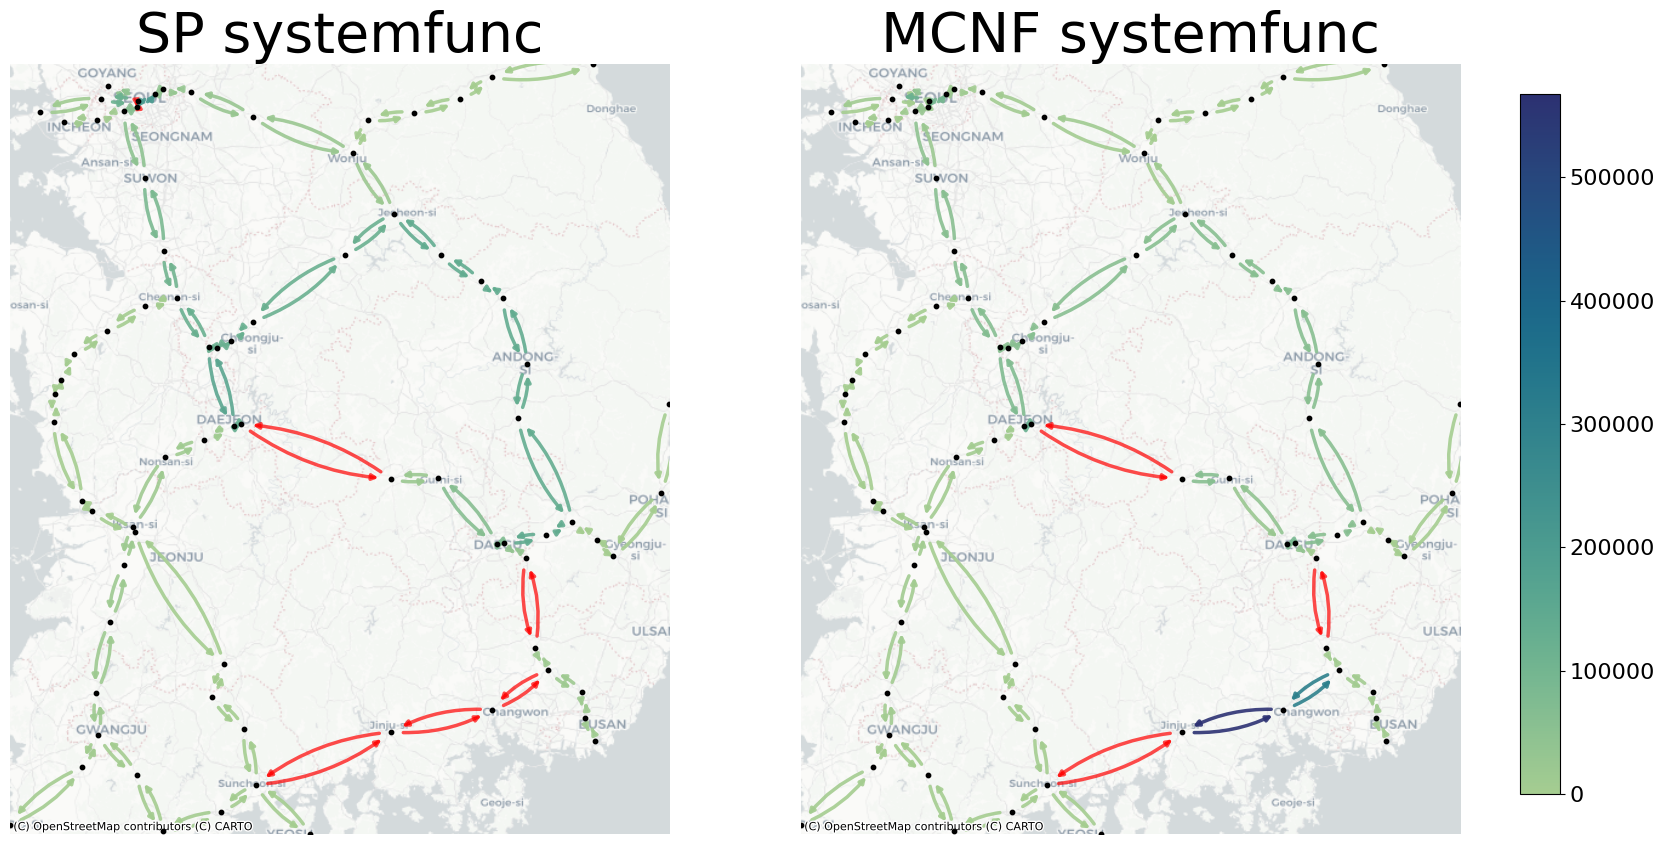

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import contextily as ctx

# 1) flows 준비
flows_sp   = edge_flows_sp   or {}
flows_mcnf = edge_flows_mcnf or {}

# 2) 전체 플로우 값 모아서 norm/cmap 설정
all_vals = list(flows_sp.values()) + list(flows_mcnf.values())
vmin, vmax = (0, max(all_vals)) if all_vals else (0,1)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = sns.color_palette("crest", as_cmap=True)

# 3) subplot 생성 (공간을 좀 더 벌려서 컬러바 자리 확보)
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True,
                         gridspec_kw={'right': 0.85})

for ax, flows, title, G in zip(
    axes,
    [flows_sp, flows_mcnf],
    ["SP systemfunc", "MCNF systemfunc"],
    [G_sp, G_mcnf]
):
    # 베이스맵 영역 설정
    xs = [x for x, y in pos.values()]
    ys = [y for x, y in pos.values()]
    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(min(ys), max(ys))
    ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)

    # 엣지 그리기: flow==0 → red, else 컬러맵
    for edge_id, (u, v) in edges.items():
        f = flows.get(edge_id, 0.0)
        rad = edge_directions.get((u, v), 0.0)

        if f == 0:
            edge_color = 'red'
            width = 2.5
            alpha = 0.7
        else:
            edge_color = cmap(norm(f))
            width = 2.5
            alpha = 0.9

        lc = nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            ax=ax,
            edge_color=[edge_color],
            width=width,
            connectionstyle=f"arc3,rad={rad}",
            arrowsize=8,
            arrowstyle='-|>',
            alpha=alpha
        )
        # zorder 설정
        if isinstance(lc, list):
            for line in lc:
                line.set_zorder(2 if f>0 else 1)
        else:
            lc.set_zorder(2 if f>0 else 1)

    # 노드 그리기
    nc = nx.draw_networkx_nodes(G, pos, node_size=10, node_color='black', ax=ax)
    nc.set_zorder(3)

    ax.set_title(title, fontsize=40)
    ax.axis('off')

# 4) 오른쪽 바깥쪽에 컬러바 전용 축 만들기
cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(all_vals)
cbar = plt.colorbar(sm, cax=cax, orientation="vertical")
cbar.ax.tick_params(labelsize=16)
#cbar.set_label("Edge Flow", fontsize=16)

plt.tight_layout()
plt.show()
